# Outliers (Aykırı Değerler)

In [8]:
# Verideki genel eğilimin dışına çıkan değerlere outliers (aykırı değer) denir.
# Burada genel eğilim ve oldukça kelimelerinin nasıl tanımlandığı önemli olacak.

In [9]:
# Aykırı değerler ne gibi problemlere sebep olabilir.

<p align="center" >    
    <img src = "grafikler/outliers.png" width= "800" />
</p>

In [10]:
# Yukarıda gördüldüğü üzere ikinci grafikteki 3 aykırı değer trend eğrisinin yönünü değiştirmiştir.

Aykırı değerin tespitinde 5 metod izlenebilir;

1. Sektör Bilgisi

2. Standart Sapma yaklaşımı

3. Z-skoru yaklaşımı

4. Boxplot ( Interquartile range-IQR ) yaklaşımı

5. LOF (Local Outlier Factor) Yöntemi (çok değişkenli olarak kullanılır)

In [11]:
# Aykırı değerlerin belirlenmesindek önemli nokta eşik değerin belirlenmesidir.
# Bu yöntemlerden biz daha çok 4.'sü olan box plot yöntemini kullanacağız.

### Aykırı Değerleri Yakalama

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Virgülden sonra 3 basamak görmek istediğimi ifade ediyorum.

Bu çalışmamızda küçük veri setinde çalışmamızı yapıpı (bu veri seti titanic veri seti olacak), daha sonrasında ise büyük veri setine (kaggle'da da yer alan home credit default risk projesinin veri seti) uyarlayacağız.

Tekrar tekrar veri okutmak (path almak vs.) işlemleri ile uğraşmamak için fonksiyon tanımlayarak hareket edeceğiz.

In [14]:
def load_application_train():
    data = pd.read_csv("datasets/application_train.csv")
    return data

df = load_application_train()
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


In [15]:
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data


df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


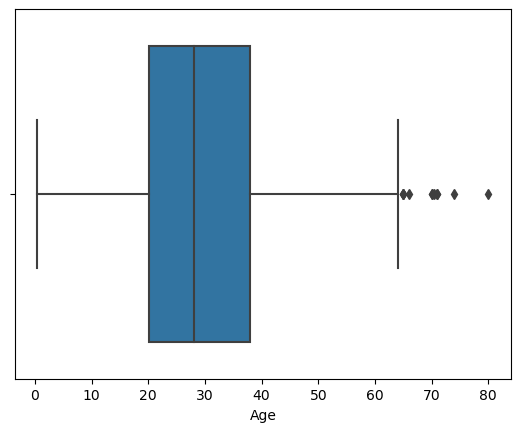

In [16]:
# Teknik grafik ve aykırı değerleri görmek istersek, boxplot kullanılır.

sns.boxplot(x = df["Age"])
plt.show()

# Yukarıda x= demezsek grafiği dikey olarak görebiliriz.
# Aşağıda aykırı değerleri görebiliyoruz.

In [17]:
# Biz yukarıda gördüğümüz aykırı değerlere erişmek istersek;

# Öncelikle değişkenimizin çeyrek değerlerine erişmemiz gerekmektedir. Daha sonra IQR hesaplanabilir. 

q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

print(low, up)

-6.6875 64.8125


In [18]:
# Şimdi outlier değerlere erişmeye çalışalım;

df[(df["Age"] < low) | (df["Age"] > up)]

# Bakıldığında çok da fazla outlier değer bulunmamaktadır.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [19]:
# Outlier değerleri bulduk lakin daha sonra bunları hızlıca bulabilmek için bunların indekslerini saklamak istersek,

df[(df["Age"] < low) | (df["Age"] > up)].index

Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [20]:
# Sadece aykırı değer var mı yok mu diye bakmak istersek;

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)

# Yukarıda axis=None olarak seçilmiştir.

True

In [21]:
# axis=1 seçilirse;

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=1)

# indeks sayıları gelir

33     True
54     True
96     True
116    True
280    True
456    True
493    True
630    True
672    True
745    True
851    True
dtype: bool

In [22]:
# axis=0 seçilirse;

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=0)

# Sütun isimleri gelir.

PassengerId    True
Survived       True
Pclass         True
Name           True
Sex            True
Age            True
SibSp          True
Parch          True
Ticket         True
Fare           True
Cabin          True
Embarked       True
dtype: bool

### Fonksiyonlaştırma

In [23]:
# Yukarıdaki işlemi her değişken için tekrarlamak çok zor olacağı için bir fonksiyon oluşturup sonrasında fonksiyon üzerinden ilerleyebiliriz.

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


    # Yukarıdaki fonksiyonu bir değişkenin alt ve üst limitlerin hızlıca hesaplanması için tanımladık.

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

    # Yukarıdaki fonksiyonu ise değişkenin içerisinde outlier değer var mı yok mı sorusunun cevabını hızlıca görebilmek için tanımladık.

In [24]:
check_outlier(df, "Age")

# Aykırı değer varmış

True

In [25]:
check_outlier(df, "Fare")

# Aykırı değer var

True

In [26]:
outlier_thresholds(df, "Age")

# Age değişkeninin alt ve üst eşik değerleri

(-6.6875, 64.8125)

In [27]:
outlier_thresholds(df, "Fare")

# Fare değişkeni için alt ve üst eşik değerleri

(-26.724, 65.6344)

In [28]:
low, up = outlier_thresholds(df, "Fare")

# Fare değişkeni için alt ve üst eşik değerlerini başka değerlere atadık

In [29]:
df[(df["Fare"] < low) | (df["Fare"] > up)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.521,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000,1,0,PC 17604,82.171,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000,1,0,PC 17572,76.729,D33,C


In [30]:
df[(df["Fare"] < low) | (df["Fare"] > up)].index

# 116 problemli değer varmış.

Int64Index([  1,  27,  31,  34,  52,  61,  62,  72,  88, 102,
            ...
            792, 802, 820, 829, 835, 846, 849, 856, 863, 879],
           dtype='int64', length=116)

Değişken sayısı fazla olan veri setleri için de bir yaklaşım sergilemem gerekir

In [31]:
dff = load_application_train()
dff.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


In [32]:
# Yukarıdaki veri setimizde 122 değişken (sütun) olduğunu görüyoruz. Bu değişkenleri analiz edebilmek için veri türlerini bilmemiz gerekir.

# Veri numerik gözüküyor ama kategorik mi?
# Verimiz kategorik olduğu halde kardinalitesi yüksek olduğu için nitelik taşııyor olabilir mi?

# Bu soruların cevaplarını verebiliyor olmamız gerekir.

# Titanik veri seti küçük olduğu için anlamıştık, lakin 122 değişkenin olduğu bir veri setinde bunu manuel yapmak pek de mümkün değildir.
# Bu durum için bir fonksiyon tanımlayacağız.

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

print("########################")
print(cat_cols)
print(num_cols)
print(cat_but_car)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
########################
['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']
['PassengerId', 'Age', 'Fare']
['Name', 'Ticket', 'Cabin']


In [34]:
df["PassengerId"]

# Bu değişkenin indeks olduğunu biliyorum dolayısıyla numerik değişkenlerden "PassengerId"yi çıkaracağız.

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

In [35]:
num_cols = [col for col in num_cols if col !="PassengerId"]
num_cols

['Age', 'Fare']

In [36]:
# Şimdi hızlıca bakalım aykırı değer var mı diye;

for col in num_cols:
    print(col, check_outlier(df, col))

# Evet iki değişken için de aykırı değer varmış.

Age True
Fare True


In [37]:
# Şimdi bir de bu çalışmamızı dff için deneyelim;

cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


In [38]:
dff.head(10)

# Aşağıda görüldüğü üzere "SK_ID_CURR" değişkeni de bu veri setinin ID'sidir. 
# Bu değişkeni numerik değişkenlerin içerisinden çıkarmak isteriz.

num_cols = [col for col in num_cols if col !="SK_ID_CURR"]

In [39]:
num_cols = [col for col in num_cols if col !="SK_ID_CURR"]

for col in num_cols:
    print(col, check_outlier(dff, col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

### Aykırı Değerlere Erişmek

In [40]:
# Burada aykırı değerlere erişme problemini de fonksiyonlaştıracağız.

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [41]:
# Yaş değişkeninin aykırı değerlerine bakalım;

grab_outliers(df, "Age")

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

       Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
33  66.000      0      0  C.A. 24579 10.500   NaN        S  
54  65.000      0      1      113509 61.979   B30        C  
96  71.000      0      0    PC 17754 34.654    A5        C  
116 70.500      0      0      370369  7.750   NaN        Q  
280 65.000      0      0      336439  7.750   NaN        Q  


In [42]:
grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

       Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
33  66.000      0      0  C.A. 24579 10.500   NaN        S  
54  65.000      0      1      113509 61.979   B30        C  
96  71.000      0      0    PC 17754 34.654    A5        C  
116 70.500      0      0      370369  7.750   NaN        Q  
280 65.000      0      0      336439  7.750   NaN        Q  


Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

### Aykırı Değer Problemini Çözme

In [43]:
###################
# Silme
###################

# Aykırı değer problemini çözmenin bir yolu da aykırı değerleri veri setinden silmektir.

In [44]:
low, up = outlier_thresholds(df, "Fare")

print(low, up)

-26.724 65.6344


In [45]:
df.shape

# veri setimizde 891 değişken bulunmaktadır.

(891, 12)

In [46]:
# Verimizdeki aykırı olmayan değerlere de bakalım;

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

# 775 adet "fare"si aykırı olmayan değişkenimiz varmış.

(775, 12)

In [47]:
# Dataframe'deki ilgili değişken için aykırı değerleri silmek için bir fonksiyon yazalım;

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [48]:
# Aşinayız artık, numerik değişkenleri bulalım ilk önce;

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [49]:
# Verimizin shape'sine bir daha bakalım;

df.shape

(891, 12)

In [50]:
for col in num_cols:
    new_df = remove_outlier(df, col)

In [51]:
# yeni veri setimizin shape'sine bakalım

new_df.shape

(775, 12)

In [52]:
# 116 gözlemi silmeyi tercih ettik.

df.shape[0] - new_df.shape[0]

116

Lakin bir hücredeki aykırılıktan dolayı o gözlemi silmeyi tercih ettiğimizde, diğer deişkenlerdeki gözlemlerden de oluyoruz. Bunun önüne geçebilmek için o aykırı değeri baskılamayı da tercih edebiliriz.

In [53]:
###################
# Baskılama Yöntemi (re-assignment with thresholds)
###################

# Bu kısımda aykırı değerleri baskılayacağız. Buradaki aykırı değerleri eşik değerlerle değiştireceğiz.

In [54]:
low, up = outlier_thresholds(df, "Fare")

print(low, up)

-26.724 65.6344


In [55]:
df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]

1      71.283
27    263.000
31    146.521
34     82.171
52     76.729
        ...  
846    69.550
849    89.104
856   164.867
863    69.550
879    83.158
Name: Fare, Length: 116, dtype: float64

In [56]:
# Bu işlemi .loc ile de yapabilirdik.

df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

1      71.283
27    263.000
31    146.521
34     82.171
52     76.729
        ...  
846    69.550
849    89.104
856   164.867
863    69.550
879    83.158
Name: Fare, Length: 116, dtype: float64

In [57]:
# Şimdi loc ile getirdiğimiz değerleri yukarıda tanımlı "up" değerine eşitlersek üst limiti baskılamış oluruz.

df.loc[(df["Fare"] > up), "Fare"] = up

# Yine aynı şekilde loc ile getirdiğimiz değerleri yukarıda tanımlı "low" değerine eşitlersek alt limiti baskılamış oluruz.

df.loc[(df["Fare"] < low), "Fare"] = low

In [58]:
# Yukarıdaki işlemimizi de fonksiyonlaştırmak istersek;

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [59]:
# Her şeye sıfırdan başlamak için df'e bir reset atacağız;

df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [60]:
# kategorik, numerik ve kardinal değişkenleri bir yakalayalım

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [61]:
# numerik değişkenlerden indeksi çıkartalım;

num_cols = [col for col in num_cols if col not in "PassengerId"]

In [62]:
# dataframe'mimizin shape'sine bakalım;

df.shape

(891, 12)

In [63]:
# Aykırı değer var mı bir kontrol edelim;

for col in num_cols:
    print(col, check_outlier(df, col))

# Aşağıda görüyoruz ki varmış.

Age True
Fare True


In [64]:
# Şimdi ise numerik değişkenlerdeki outlier değerleri baskılayacağız;

for col in num_cols:
    replace_with_thresholds(df, col)

In [65]:
# Bir kez daha kontrol edelim aykırı değer kalmış mı;

for col in num_cols:
    print(col, check_outlier(df, col))

# Kalmadığını görüyoruz.

Age False
Fare False


### Çok Değişkenli Aykırı Değer Analizi: Local Outlier Factor

In [66]:
# Çok değişkenli aykırı değer; birbiri ile alakalı değişkenlerin birbiri ile uyumsuzluk göstermesidir.
# Yani tek başına aykırı olamayacak bazı değerler birlikte aykırılık oluşturabilir.

# Örneğin bir kişinin yaşı 17 olup, 3 kere evlenmiş olması aykırı değer olarak kabul edilebilir.

<p align="center" > 
    <img src = "grafikler/2560px-LOF-idea.svg.png" width = "300" />
</p>

Local Outlier Factor (LOF) aykırı değer belirleme yöntemidir. LOF yöntemi ile gözlemleri bulundukları yerde yoğunluk tabanlı skorlayarak aykırı değer olabilecek değerleri tanıma imkanı sağlar.

Bir noktanın lokal yoğunluğu ise ilgili noktanın etrafındaki komşulukları ifade eder. Eğer ki bir nokta komşularının yoğunluğundan anlamlı derece de uzak ise bu nokta daha seyrek bir bölgededir ve aykırı değer olabilir yorumu yapılır.

Yukarıdaki göreseldeki A noktası diğer noktalardan anlamlı derecede uzaktır, aykırı değer olabilir yorumunu yapabiliriz.

<p align="center" >    
    <img src = "grafikler/2880px-LOF.svg.png" width = "500"/>

</p>

LOF yöntemi için yukarıdaki 2 boyutlu grafiğimizi ele alalım. LOF yöntemi sonucu bizler bir skor hesaplarız ve bu hesabın sonucu 1'e ne kadar yakınsa bizim için o değerin inlier (outlier değil) olma olasılığı o kadar fazladır. 

Eğer ki bu skor 1'den ne kadar uzaksa ilgili gözlemin outlier olma olasılığının arttığını görürüz.

Tabi bizler de bu skorlar için eşik değerler belirleyebiliriz. Yukarıdaki grafik için eşik değerimizi 5 olarak belirlersek 2 bariz değeri outlier olmuş olur.

In [67]:
# Elimizde iki değişken olduğu zaman yukarıdaki grafik gibi bir görselleştirme yapılabilir. 
# Lakin elimizde yüzlerce değişken var ise ne yapacağız?

# Elimizde yüzlerce değişken var ve biz bu değişkenleri iki boyutta göstermek istiyorsak;
# elimizdeki değişkenlerdeki bilgilerin büyük bir miktarını taşıdığı varsayılan 
# iki değişkene indirgeyebilirsek bu soruna bir çözüm getirmiş oluruz.

# Bunu da PCA (Principal Component Analsysis veya Temel Bileşen Analizi) yöntemi ile yapabiliriz.

In [68]:
# diamonds verisini seaborn kütüphanesinden sadece sayısal değişkenlerini getirecek ve eksik değerleri drop ederek çağırıyoruz.

df = sns.load_dataset('diamonds')
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
df.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [69]:
# bizim chech_outlier fonksiyonumuz bulunmaktaydı, aykırı değer olup olmadığını bir kontrol etmek istersek;

for col in df.columns:
    print(col, check_outlier(df, col))

# Görüldüğü üzere bütün değişkenlerimizde aykırı değer bulunmaktadır.

carat True
depth True
table True
price True
x True
y True
z True


In [70]:
# carat değişkeninde kaç adet aykırı değer olduğunu bulmak istersek;

low, up = outlier_thresholds(df, "carat")

df[(df["carat"] < low) | (df["carat"] > up)].shape

# carat değişkeni için  1889 adet aykırı değer olduğunu görebiliriz.

(1889, 7)

In [71]:
# Veri setindeki değişken sayısını görmek istersek;

df.shape

# 53490 değişken olduğunu görüyoruz.

(53940, 7)

In [72]:
# depth değişkeninde kaç adet aykırı değer olduğunu bulmak istersek;

low, up = outlier_thresholds(df, "depth")

df[(df["depth"] < low) | (df["depth"] > up)].shape

# 2545 adet aykırı değer olduğunu görebiliriz.

(2545, 7)

### Yorum

Şimdi verimize baktığımızda 53940 adet değişken olduğunu görüyoruz. Verimizdeki aykırı değerleri değiştirmek (silmek veya baskılamak) istersek bir takım problemlerele kaşılaşacağız.

 "carat" değişkenini ele alalım. 1889 adet aykırı değişken bulunuyor. Bu aykırı değişkenlere müdahale etmek istersek, carat değişkeninin %3'lük bir kısmına müdahale etmiş oluruz. Geliştiricinin yorumlamasına bağlı olarak bu oranın yüksek bir oran olduğunu söyleyebiliriz.

 "depth" değişkenine müdahale etmek istersek, değişkenin %4'üne müdahale etmiş oluruz. Her değişkenine müdahael ettiğimizde, kümülatif olarak totalde belki de verinin %5'lik bir kısmına müdahalede bulunmuş olacağız.

Daha görmedik lakin **makine öğrenmesinde** karar ağacı kullandığımız yerlerde veriye zaten pek de müdahale etmiyor olmamız gerekmektedir.

Peki bu durumda ne yapmamız gerekiyor. Notebook'un başlarında **outlier_tresholds** diye bir değişken tanımlamıştık. 
Bu değişkeni tanımlarken de interquartile range (iqr) hesaplaması yapmıştık. 

Bu formülü hatırlayacak olursak **IQR = Q3 - Q1**'di. Q3 üçüncü çeyrek, Q1 ise birinci çeyrekti. 

Şimdi biz bu IQR değerini tam çeyreklerden değil de verinin ilk %2,5'luk ve son %2,5'luk değerlerin farkı olarak hesaplarsak, doğal olarak eşik değerlerimiz konusunda daha esnek davranmış oluruz. 

IQR'in tanımı çeyrekler açıklığı olsa da biz verimizdeki aykırı değerler üzerinde alacağımız aksiyonlarda biraz daha esnek olma yönünde kararlar vereceğiz ve gerçekten aykırı sayılabilecek değerleri bulmaya çalışacağız.

In [73]:
# Bu duruma bir örnek vermek istersek;

df_titanic = load()

low_titanic_age, up_titanic_age = outlier_thresholds(df_titanic, "Age")
print(low_titanic_age, up_titanic_age)

-6.6875 64.8125


In [74]:
df_titanic[(df_titanic["Age"] < low_titanic_age) | (df_titanic["Age"] > up_titanic_age)]["Age"]

# Aşaıdaki veriler incelendiğinde eb yüksek yaşın 80 olduğunu görüyoruz, 80 yaşında birisinin de gemide olması anormal bir durum değildir.
# Örneğin 150 gibi bir değer olsaydı bu değere aykırıdır diyebilirdir.

# Lakin direk çeyrekler açıklığına bakıldığında yaşı 66 olan birisinin bile aykırı bir değer olduğunu söylememiz gerekir.
# Bu sebeple aykırı değer hesaplanmasında daha esnek olunabilir.

33    66.000
54    65.000
96    71.000
116   70.500
280   65.000
456   65.000
493   71.000
630   80.000
672   70.000
745   70.000
851   74.000
Name: Age, dtype: float64

Yukarıdaki işlemler tek bir değişen üzerinden aykırı değer tespitine yönelik bir hatırtama ve yorumdu.

In [75]:
# Şimdi çok factorlü bir şekilde incelemek istersek, LOF metodunu kullanacaktır.

# Bunun için bir LocalOutlierFactor() fonsiyonunu kullanıyoruz ve içerisine argüman giriyoruz. 
# Burada argümanın in tanımlı değeri olan 20'yi kullanmayı tercih edebiliriz.
# veya bu komşuluk değerini arttırıp azaltabiliriz.

# Lakin burada bir sorun karşımıza çıkmaktadır. 
# Bu değiştime sonucunda hesaplanan komşuluk skorlarının hangisinin daha iyi olduğunun yorumlayamamaktayız.

clf = LocalOutlierFactor(n_neighbors=20)

In [76]:
# Yöntemimizi getirdik. Şimdi veri setimize uygulayalım.

clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [77]:
# Şimdi ise bu değerleri kaydediyoruz;

df_scores = clf.negative_outlier_factor_
df_scores

# Aşağıdaki değerler local outlier factor skorlarıdır. Lakin yukarıda kullandığımız metod bize bu skorları eksi değerler ile verdi.
# df_scores = -df_scores
# Yukarıdaki gibi skorları -1 ile çarparak + değerlere dönüşüm yapılabilir.
# Lakin biz bunları eksi değerlere göre değerlendiriyor olacağız. 

array([-1.58352526, -1.59732899, -1.62278873, ..., -1.06721815,
       -1.00809552, -1.00849038])

In [78]:
# Yani buradaki değerlerin 1'e yakın olması inlier değer olduğunu gösteriyordu, 
# şu anda ise -1'e yakın olması inlier değer olduğunu gösterecek.

# Bu sebeple sıralayıp değerlerimizi görmek istersek;

np.sort(df_scores)[0:5]


array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

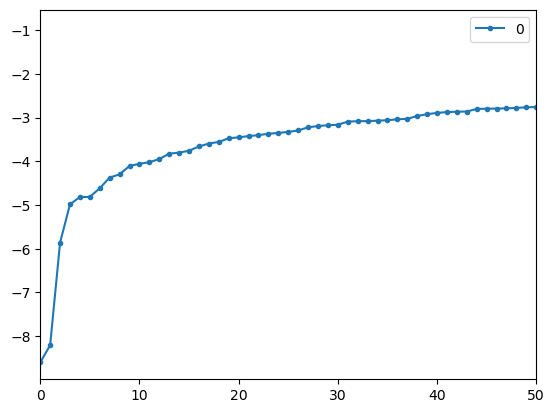

In [79]:
# Burada bir eşik değer belirleyip o değerden küçük olanlar outlier'dır dememiz gerekmektedir.
# Lakin bu eşik değer nasıl belirlenbilir?

# Bunun için elbow metodunu uygulayacağız.

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

# "xlim=" argümanına kaç değer gösterileceğini söyleriz.
# "style=" argümanına "*-" değeri ile grafiğin çizgi grafi olması gerektiği ve değerleri belirtmesi gerektiğini ifade ediyoruz.

# Aşağıdaki grafik bir dirseğe benzemekte ve biz en keskin, sert dönüşün olduğu yeri eşik değer olarak belirleyeceğiz.
# Burada ise 3. indekste en keskin dönüşü görebiliyoruz
# Bir geliştirici olarak burayı eşik değer olarak yorumlayabilirim.

In [80]:
# Eşik değeri bulmak için ise;

th = np.sort(df_scores)[3]
th

# Eşik değerimizi bulduk.

-4.984151747711709

In [81]:
# Şimdi ise aykırı değer sayılan gözlemlerimize bakalım;

df[df_scores < th]

# Baktığımızda aşağıdaki değerlerin gözlemler açısından neden aykırı olduğunu anlayamasak da bir bütün olarak incelendiğinde,
# 3 aykırı değer olduğunu görüyoruz.

# Halbuki daha öncesinde sadece bir değişkende binlerce aykırı değer yakalayabiliyorduk.

,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120


### Yorum

Bizler yukarıda binlerce aykırı değer olmasını çok fazla aykırı değer var şeklinde yorumlamıştık.

Peki bir anda aykırı değer sayısının 3 olması bizi acaba aykırı değerleri yeterince bulamamak yönünde tedirgin ederse ne yapmamız gerekir **?**

In [82]:
# Verimizin betimsel istatistiklerini bi getirelim;

df.describe([0.01, 0.05, 0.25, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.400,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.000,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,56.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,950.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,4.710,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,4.720,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,2.910,3.530,4.040,4.520,5.150,31.800


Gözlem değerlerini betimsel istatistik tablomuzla yorumlayalım.

    * İlk satırdaki verilerin ortalamaya olan uzaklığına bir bakalım;
        * carat ortalama değere yakın ve max ve min noktalardan uzak,
        * depth maksimum değere çok yakın,
        * table ortalamaya yakın,
        * price değeri %25'lik değer ile %50'lik değer arasında,
        * x, y ve z değerleri de ortalamaya yakın

#### Burada depth değeri "78.2" değerinden büyük ama, outlier olarak belirlenmeyen bir değer olmasına rağmen bu değer neden outlier olarak belirlenmiş gibi bir soru sorabiliriz. Buna cevap olarak değişkenler arasında bir uyumsuzluk olmuş olabilir cevabı verilebilir. Örneğin depth değeri çok fazla ama fiyat buna göre ortalamanın altında diye bir yorum getirilebilir.


    * İkinci satırdaki verilerin ortalamaya olan uzaklığına bir bakalım;
        * z değeri maksimum olan gözlem dolayısıyla outlier olması mantıklı diyebiliriz.

In [83]:
# Şimdi bu aykırı değerlerin index'lerini getirmek istersek;

df[df_scores < th].index

Int64Index([41918, 48410, 49189], dtype='int64')

In [84]:
# Bu verileri df'den silmek istersek;

df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)

,carat,depth,table,price,x,y,z


In [85]:
# Peki bunları baskılamak istersek nasıl yapacağız?

# Baskılamak istersek karşımıza şöyle bir sorun çıkmaktadır, biz hangi değeri hangi değer ile baskılayacağız.
# Yerine ortalama bir gözlemin değerini getirebiliriz. Lakin bu da duplicate oluşturabilir.

# Bu seneryo için 3 adet outlier olması 53490 değer arasında pek de önemli bir sayı olmadığı için direk silebiliriz.

### Önemli not !!!

Ağaç yöntemlerinde veriye müdahale edilmesini pek tercih etmiyoruz. Ağaç yöntemi uygulanacak oldunduğunda yukarıdaki gibi tek değişkenli outlier tespitinde uç noktalardan bu kadar da olmaz diyebileceğimiz ([%2.5 , % 97,5] veya [%1 , % 99]) noktalardan sonraki gözlemlerin sade ilgili sütunlarını baskılamayı tercih edebiliriz.

Peki LOF yöntemi bizim ne zaman işimize yarayacak diyebiliriz?

LOF yöntemi tam da buradaki gibi göz ardı edebileceğimiz, sildiğimizde bir sorun teşkil etmeyecek zamanlarda kullanılabilir. Eğer ki LOF yöntemi ile yüzlerce veya binlerce silindiğinde veride kayıp oluşturacak veya duplicate olduğunda verimizi bozacak durumlarda kullanılmaz.